# Music

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
path = Path('data/composers/notewise/piano_solo/note_range38/sample_freq12')
path.ls()[:5]

[PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/jazz'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/ravel'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/bach'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/schumann'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/test1')]

In [10]:
import music21
from IPython.display import Image, Audio

## Get seed

In [4]:
idx = 10
folder_idx = 2 # 2 = bach
seed_len = 250

file = path.ls()[folder_idx].ls()[idx]
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len])

note_offset = 45 if 'note_range38' in str(file) else 33
sample_freq = 12 if 'sample_freq12' in str(file) else 4

In [5]:
seed

'p18 p30 wait5 endp18 endp30 wait1 p29 wait2 endp29 wait1 p30 wait2 endp30 wait1 p17 p32 wait5 endp17 endp32 wait1 p30 wait2 endp30 wait1 p29 wait2 endp29 wait1 p15 p30 wait5 endp15 wait7 p10 wait2 endp30 wait1 p32 wait2 endp10 endp32 wait1 p29 wait2 endp29 wait1 p30 wait2 endp30 wait1 p11 p32 wait2 endp32 wait1 p25 wait2 endp11 endp25 wait1 p34 wait2 endp34 wait1 p25 wait2 endp25 wait1 p13 p35 wait2 endp35 wait1 p25 wait2 endp13 endp25 wait1 p37 wait5 endp37 wait1 p6 p34 endp34 p35 endp35 wait3 p32 p34 endp34 wait2 endp6 endp32 wait1 p18 p30 wait2 endp30 wait1 p32 wait2 endp18 endp32 wait1 p17 p34 wait2 endp34 wait1 p36 wait2 endp17 endp36 wait1 p15 p37 wait2 endp37 wait3 endp15 wait1 p13 p25 wait5 endp13 endp25 wait1 p24 p32 wait2 endp24 wait1 p25 wait2 endp25 wait1 p24 p27 wait2 endp32 wait3 endp24 endp27 wait1 p25 wait2 endp25 wait1 p24 wait2 endp24 wait1 p22 p25 p37 wait2 endp37 wait1 p36 wait2 endp22 endp36 wait1 p34 wait2 endp34 wait1 p32 wait2 endp32 wait1 p17 p37 wait2 endp25 

### Util functions

In [22]:

def write_midi(s, filename, output_folder):
    fp = s.write('midi', fp=output_folder/filename)
    
def string_inds_to_stream(string, sample_freq, note_offset, chordwise):
    score_i = string.split(" ")
    return arrToStreamNotewise(score_i, sample_freq, note_offset)
      
def arrToStreamNotewise(score, sample_freq, note_offset):
    speed=1./sample_freq
    piano_notes=[]
    violin_notes=[]
    time_offset=0
    
    i=0
    while i<len(score):
        if score[i][:9]=="p_octave_":
            add_wait=""
            if score[i][-3:]=="eoc":
                add_wait="eoc"
                score[i]=score[i][:-3]
            this_note=score[i][9:]
            score[i]="p"+this_note
            score.insert(i+1, "p"+str(int(this_note)+12)+add_wait)
            i+=1
        i+=1
        
    for i in range(len(score)):
        if score[i] in ["", " ", "<eos>", "<unk>"]:
            continue
        elif score[i][:3]=="end":
            if score[i][-3:]=="eoc":
                time_offset+=1
            continue
        elif score[i][:4]=="wait":
            time_offset+=int(score[i][4:])
            continue
        else:
            # Look ahead to see if an end<noteid> was generated
            # soon after.  
            duration=1
            has_end=False
            note_string_len = len(score[i])
            for j in range(1,200):
                if i+j==len(score):
                    break
                if score[i+j][:4]=="wait":
                    duration+=int(score[i+j][4:])
                if score[i+j][:3+note_string_len]=="end"+score[i] or score[i+j][:note_string_len]==score[i]:
                    has_end=True
                    break
                if score[i+j][-3:]=="eoc":
                    duration+=1

            if not has_end:
                duration=12

            add_wait = 0
            if score[i][-3:]=="eoc":
                score[i]=score[i][:-3]
                add_wait = 1

            try: 
                new_note=music21.note.Note(int(score[i][1:])+note_offset)    
                new_note.duration = music21.duration.Duration(duration*speed)
#                 print(new_note, new_note.duration)
                new_note.offset=time_offset*speed
                if score[i][0]=="v":
                    violin_notes.append(new_note)
                else:
                    piano_notes.append(new_note)                
            except:
                print("Unknown note: " + score[i])

            

            
            time_offset+=add_wait
                
#     violin=music21.instrument.fromString("Violin")
#     piano=music21.instrument.fromString("Piano")
#     violin_notes.insert(0, violin)
#     piano_notes.insert(0, piano)
    violin_stream=music21.stream.Stream(violin_notes)
    piano_stream=music21.stream.Stream(piano_notes)
    main_stream = music21.stream.Stream([violin_stream, piano_stream])
    return piano_stream, violin_stream, main_stream

In [23]:
piano_stream, violin_stream, stream_out=string_inds_to_stream(seed, 12, note_offset, False)

In [14]:
# piano_stream.timeSignature = meter.TimeSignature('2/4')

NameError: name 'meter' is not defined

In [18]:
fctr = 2 # scale (in this case stretch) the overall tempo by this factor
# newscore = piano_stream.scaleOffsets(fctr).scaleDurations(fctr)
newscore = piano_stream.augmentOrDiminish(fctr)

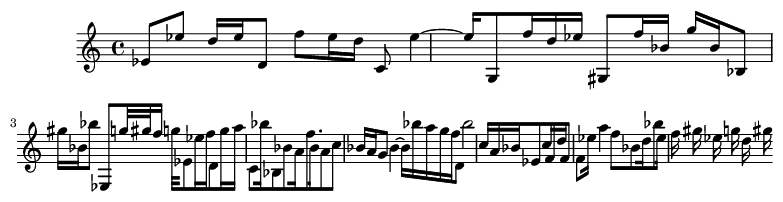

In [24]:
Image(filename=str(piano_stream.write('lily.png')))

In [25]:
piano_stream.show('midi')

In [163]:
[(n, n.offset, n.duration) for n in piano_stream][:20]

[(<music21.note.Note F>, 11.25, <music21.duration.Duration 1.0>),
 (<music21.note.Note C#>, 12.0, <music21.duration.Duration 3.0>),
 (<music21.note.Note F>, 12.0, <music21.duration.Duration 2.25>),
 (<music21.note.Note F>, 12.75, <music21.duration.Duration 0.75>),
 (<music21.note.Note G#>, 13.5, <music21.duration.Duration 0.75>),
 (<music21.note.Note C#>, 14.25, <music21.duration.Duration 1.75>),
 (<music21.note.Note F#>, 14.25, <music21.duration.Duration 1.0>),
 (<music21.note.Note E->, 15.0, <music21.duration.Duration 3.0>),
 (<music21.note.Note F#>, 15.0, <music21.duration.Duration 2.5>),
 (<music21.note.Note C#>, 15.75, <music21.duration.Duration 0.75>),
 (<music21.note.Note C>, 16.5, <music21.duration.Duration 0.75>),
 (<music21.note.Note B->, 17.25, <music21.duration.Duration 0.75>),
 (<music21.note.Note F>, 17.25, <music21.duration.Duration 0.25>),
 (<music21.note.Note F#>, 17.25, <music21.duration.Duration 0.25>),
 (<music21.note.Note F>, 18.0, <music21.duration.Duration 4.75>)

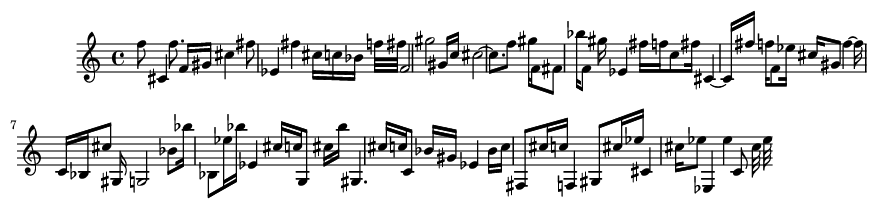

In [175]:
Image(filename=str(piano_stream.write('lily.png')))

In [156]:
stream2 = stream.Stream()
n3 = note.Note('D#5') # octave values can be included in creation arguments
stream2.repeatAppend(n3, 4)
stream2.show('midi')

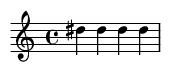

In [176]:
Image(filename=str(stream2.write('lily.png')))

In [222]:
pChords = piano_stream.chordify()

In [209]:
pChords = pChords.augmentOrDiminish(fctr)

In [223]:
[(n, n.offset, n.duration) for n in pChords.flat][:20]

[(<music21.note.Rest rest>, 0.0, <music21.duration.Duration 3.75>),
 (<music21.chord.Chord F5>, 3.75, <music21.duration.Duration 0.25>),
 (<music21.chord.Chord C#4 F5>, 4.0, <music21.duration.Duration 1/12>),
 (<music21.chord.Chord C#4 F5>,
  Fraction(49, 12),
  <music21.duration.Duration 1/6>),
 (<music21.chord.Chord C#4 F4 F5>, 4.25, <music21.duration.Duration 0.25>),
 (<music21.chord.Chord C#4 G#4 F5>, 4.5, <music21.duration.Duration 0.25>),
 (<music21.chord.Chord C#4 C#5 F#5>, 4.75, <music21.duration.Duration 0.25>),
 (<music21.chord.Chord E-4 C#5 F#5>, 5.0, <music21.duration.Duration 1/12>),
 (<music21.chord.Chord E-4 C#5 F#5>,
  Fraction(61, 12),
  <music21.duration.Duration 1/6>),
 (<music21.chord.Chord E-4 C#5 F#5>, 5.25, <music21.duration.Duration 1/12>),
 (<music21.chord.Chord E-4 C#5 F#5>,
  Fraction(16, 3),
  <music21.duration.Duration 1/6>),
 (<music21.chord.Chord E-4 C5 F#5>, 5.5, <music21.duration.Duration 0.25>),
 (<music21.chord.Chord E-4 B-4 F5 F#5>,
  5.75,
  <music2

In [185]:
pChords.show('midi')

In [210]:
pChords.show('midi')

In [189]:
meter.TimeSignature('4/4').beatDuration

<music21.duration.Duration 1.0>

In [183]:
pChords.timeSignature = meter.TimeSignature('2/4')

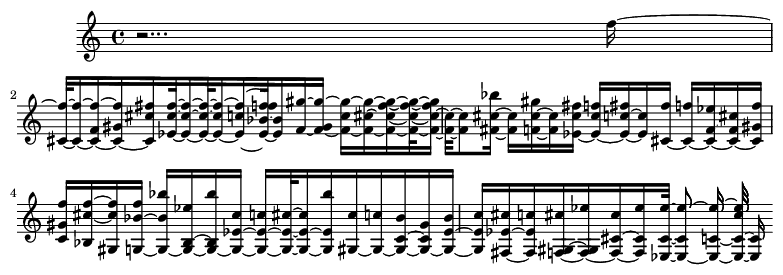

In [224]:
Image(filename=str(pChords.write('lily.png')))

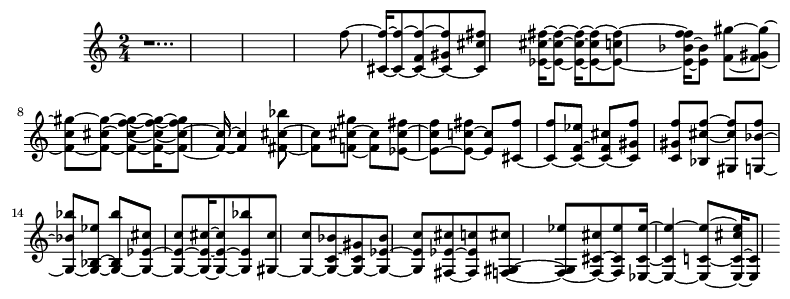

In [211]:
Image(filename=str(pChords.write('lily.png')))

In [ ]:
[(n, n.offset, n.duration) for n in stream_out.flat]

In [95]:
c = s[0].flat[15]

In [ ]:
[(n, n.offset, n.duration) for n in s[0].flat]

In [64]:
stream_out

<music21.stream.Stream 0x7fe112ae8978>

In [ ]:
s.show('midi')

In [ ]:
stream_out.show('midi')

In [ ]:
Image(filename=str(s.write('lily.png')))

In [124]:
[(n, n.offset, n.duration) for n in s.flat][:20]

[(<music21.instrument.Piano Piano>, 0.0, <music21.duration.Duration 0.0>),
 (<music21.instrument.Piano Piano>, 0.0, <music21.duration.Duration 0.0>),
 (<music21.note.Rest rest>, 0.0, <music21.duration.Duration 3.75>),
 (<music21.note.Rest rest>, 0.0, <music21.duration.Duration 4.25>),
 (<music21.note.Rest rest>, 0.0, <music21.duration.Duration 4.75>),
 (<music21.note.Note F>, 3.75, <music21.duration.Duration 0.25>),
 (<music21.note.Note C#>, 4.0, <music21.duration.Duration 1.0>),
 (<music21.note.Note F>, 4.25, <music21.duration.Duration 0.25>),
 (<music21.note.Note G#>, 4.5, <music21.duration.Duration 0.25>),
 (<music21.note.Note C#>, 4.75, <music21.duration.Duration 0.5>),
 (<music21.note.Note F#>, 4.75, <music21.duration.Duration 0.25>),
 (<music21.note.Rest rest>, 4.75, <music21.duration.Duration 13.0>),
 (<music21.note.Note E->, 5.0, <music21.duration.Duration 1.0>),
 (<music21.note.Note C>, 5.5, <music21.duration.Duration 0.25>),
 (<music21.note.Note B->, 5.75, <music21.duration.D

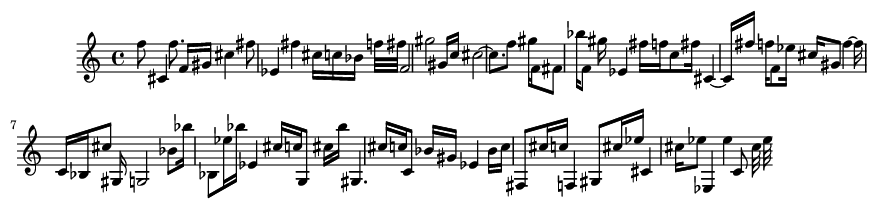

In [61]:
Image(filename=str(stream_out.write('lily.png')))

In [154]:
write_midi(stream_out, 'test.mid', out_dir)

In [144]:

def write_mid_mp3_wav(stream, fname, sample_freq, note_offset, out, chordwise):
    piano_stream, violin_stream, main_stream=string_inds_to_stream(stream, sample_freq, note_offset, chordwise)
    write_midi(stream_out, fname, out)
    base=out/fname[:-4]
    os.system(f'./mid2mp3.sh {base}.mid')
    os.system(f'mpg123 -w {base}.wav {base}.mp3')    
    

In [145]:
out_dir = Path('tmp_out')
tmp_file = 'testfile.mid'
midi_file = out_dir/tmp_file
if midi_file.exists(): midi_file.unlink()

In [146]:
result = write_mid_mp3_wav(seed, fname=tmp_file, 
                           sample_freq=sample_freq, note_offset=note_offset, 
                           out=out_dir, chordwise=False)

In [118]:
pChords.show('midi')

In [112]:
write_midi(piano_stream, tmp_file, out_dir)

In [113]:
from music21 import *
from IPython.display import Image

In [114]:
mf = midi.MidiFile()
mf.open(midi_file)
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)

In [50]:
d0 = s.flat[15]

In [52]:
d0.duration

<music21.duration.Duration 0.0>

In [116]:
Image(filename=str(s.write('lily.png')))

LilyTranslateException: Cannot translate an object of zero duration <music21.duration.Duration 0.0>

In [106]:
s.show('midi')

In [ ]:
Image(filename=str(s.write('lily.png')))

In [182]:
%debug

> /home/ubuntu/anaconda3/envs/musical_neural_net/lib/python3.7/site-packages/music21/lily/translate.py(1289)lySimpleMusicFromNoteOrRest()
   1287             simpleElementParts.append("s ")
   1288         elif 'Rest' in c:
-> 1289             if noteOrRest.hasStyleInformation and noteOrRest.hideObjectOnPrint:
   1290                 simpleElementParts.append("s ")
   1291             else:

ipdb> noteOrRest
<music21.note.Rest rest>
ipdb> noteOrRest.hasStyleInformation
True
ipdb> noteOrRest.hideObjectOnPrint
*** AttributeError: 'Rest' object has no attribute 'hideObjectOnPrint'
ipdb> quit


# 

In [97]:
b = corpus.parse('bach/bwv66.6')

In [100]:
list(b.flat)

 <music21.instrument.Instrument P1: Soprano: Instrument 1>,
 <music21.instrument.Instrument P2: Alto: Instrument 2>,
 <music21.instrument.Instrument P3: Tenor: Instrument 3>,
 <music21.instrument.Instrument P4: Bass: Instrument 4>,
 <music21.clef.TrebleClef>,
 <music21.clef.TrebleClef>,
 <music21.clef.BassClef>,
 <music21.clef.BassClef>,
 <music21.key.Key of f# minor>,
 <music21.key.Key of f# minor>,
 <music21.key.Key of f# minor>,
 <music21.key.Key of f# minor>,
 <music21.meter.TimeSignature 4/4>,
 <music21.meter.TimeSignature 4/4>,
 <music21.meter.TimeSignature 4/4>,
 <music21.meter.TimeSignature 4/4>,
 <music21.note.Note C#>,
 <music21.note.Note E>,
 <music21.note.Note A>,
 <music21.note.Note A>,
 <music21.layout.StaffGroup <music21.stream.Part Soprano><music21.stream.Part Alto><music21.stream.Part Tenor><music21.stream.Part Bass>>,
 <music21.note.Note B>,
 <music21.note.Note B>,
 <music21.note.Note G#>,
 <music21.note.Note A>,
 <music21.note.Note F#>,
 <music21.note.Note C#>,
 <mus